# Week 13 Assignment: Topic Modeling

**DATA110**  
*Brian Roepke*  

Using the same women's clothing dataset from Midterm #2, perform Topic Modeling using LDA using either packages: Gensim  or sklearn on the reviews text.  


Given that there are 6 departments, you can use  6 topics.  Bonus if you apply coherence computations against multiple models for model selection, in order to determine the optimal number of topics.



References:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py

In [1]:
import numpy as np
import pandas as pd
import string
import re
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf
from gensim.models.lsimodel import LsiModel
from gensim.models.ldamodel import LdaModel

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [3]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [4]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

In [5]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [6]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [7]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

In [8]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [9]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


In [10]:
wordlen = df['Text'].str.split().map(lambda x: len(x))
wordlen.describe()

count    22626.000000
mean        63.121321
std         29.086751
min          2.000000
25%         39.000000
50%         62.000000
75%         92.000000
max        121.000000
Name: Text, dtype: float64

In [11]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [12]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    # Make lower
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    
    # Remove stop words
    text_filtered = [word for word in text if not word in useless_words]
    
    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [13]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [14]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

In [15]:
clean_docs = df['Text_Processed'].to_list()

# first 5 docs
clean_docs[:5]

['absolutely wonderful silky sexy comfortable ',
 'love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite  love length hit little knee would definitely true midi someone truly petite ',
 'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c ',
 'favorite buy love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment ',
 'flattering shirt shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt ']

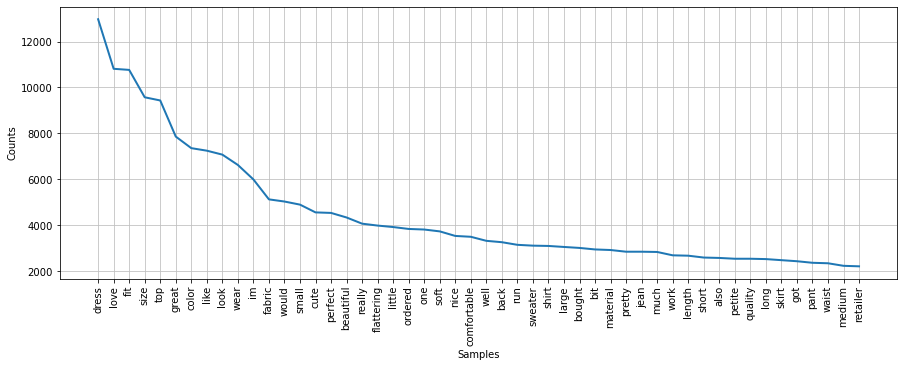

In [16]:
texts = "".join(clean_docs)
word_tokens = word_tokenize(texts)
#fdist.most_common(50)

plt.figure(figsize=(15, 5)) 
fdist = FreqDist(word_tokens)
fdist.plot(50);

# Clustering
The clustering method for topic identification calculates a similarity measure for each word to a given number of cluster centers after transforming each word into a numeric value via `TF-IDF` methods. The words are then assigned to their nearest clusters.  In clustering, each word is assigned to a single cluster.

## Determine the Optimal Number of Clusters

To select the best number of clusters, we'll use the Elbow method.  Per [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

> *In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, such as the number of principal components to describe a data set.*

[Tutorial: How to determine the optimal number of clusters for k-means clustering](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [17]:
#vectorization of features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_docs)

X.shape

(22626, 17464)

In [18]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

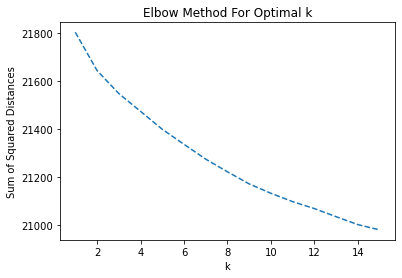

In [19]:
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
ax.lines[0].set_linestyle("--")
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Conclusion:** Based on this method, the appropriate number of clusters is not totally clear. 

## Silhouette Score

The best value is `1`, and the worst value is `-1`. Values near `0` indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette_score#sklearn.metrics.silhouette_score

In [20]:
X.shape

(22626, 17464)

In [21]:
def get_silhouette_score(X, k):
    for n_clusters in range(4, k):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        y = clusterer.fit_predict(X)

        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, silhouette_score(X, y)))
        
get_silhouette_score(X, 10)     

For n_clusters = 4 The average silhouette_score is: 0.005998668790287497
For n_clusters = 5 The average silhouette_score is: 0.0078059482504735725
For n_clusters = 6 The average silhouette_score is: 0.008306107776129817
For n_clusters = 7 The average silhouette_score is: 0.009123274352224143
For n_clusters = 8 The average silhouette_score is: 0.008214071775304503
For n_clusters = 9 The average silhouette_score is: 0.008739443596400677


**Conclusion:** All of the silhouette scores are close to `0`.  No negative values are suggesting that there are not overlapping clusters. However, there is not a stand-out number.  The highest scoring is `7` clusters, close to our `6` Department Names in the dataset.

## Clustering Model

Based on the above analysis, there was not a clear winner for the total number of topics.  We know from our dataset that there were `6` product categories, and we can use that number for our model. 

In [22]:
true_k = 6
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=42)
kmeans.fit(X)


print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

results_dict = {}


for i in range(true_k):
    terms_list = []
    
    for ind in order_centroids[i, :15]:  
        terms_list.append(terms[ind])
    
    results_dict[f'Custer{i}'] = terms_list
    
df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

Top terms per cluster:


,Custer0,Custer1,Custer2,Custer3,Custer4,Custer5
0,sweater,dress,small,jacket,jean,top
1,color,love,size,tee,pant,love
2,love,fit,run,love,great,great
3,like,beautiful,large,great,love,cute
4,fit,great,medium,color,fit,fit
5,look,size,fit,cute,comfortable,color
6,shirt,perfect,ordered,fit,perfect,look
7,fabric,wear,im,wear,pair,wear
8,beautiful,flattering,big,perfect,color,size
9,skirt,im,wear,soft,soft,like


**Observations**:  
- Cluster `0` contains the word skirt and could indicate the category as `bottoms`. 
- Cluster `1` first word is `dress`, which matches a department of the same name.
- Cluster `2` does not have any words that directly match a department name.
- Cluster `3` top word is `top`, which matches the department of the same name or possibly `intimates` based on the other words.
- Cluster `4` contains the word shirt and `top`, which could match `tops` as well. 
- Cluster `5` has `sweater`, `pant`, and `jean` most matching the `bottoms` category.

In [23]:
# assign the data labels back to the dataframe
df['clusters'] = kmeans.labels_

In [24]:
df.sample(10, random_state=121)

,Age,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name,Text,text_len,Text_Processed,clusters
17342,37,3,0,4,Bottoms,Pants,Ick I look like a stuffed sausage in these pan...,228,ick look like stuffed sausage pant even went s...,0
10222,65,4,1,5,Tops,Knits,It does snag easily which stinks because it's...,123,snag easily stink darling love piece hope does...,0
12990,43,1,0,0,Intimate,Lounge,Runs way too big I really wanted to love this ...,130,run way big really wanted love piece large im ...,2
17026,45,3,1,1,Tops,Blouses,"Almost ,but not quite... I really wanted to lo...",525,almost quite really wanted love top got much f...,5
12222,42,3,0,3,Tops,Sweaters,Unflattering cut Love the warm fuzzies of this...,211,unflattering cut love warm fuzzies sweater lov...,0
19477,77,3,0,1,Dresses,Dresses,Beware I just got this dress in the mail and t...,507,beware got dress mail tried loved fit perfect ...,1
17368,65,5,1,2,Bottoms,Pants,Love these pants Love these pants . very flatt...,346,love pant love pant flattering comfortable coo...,4
20026,25,5,1,0,Bottoms,Skirts,Classic and feminine I bought this skirt in th...,525,classic feminine bought skirt store month ago ...,2
1281,50,5,1,1,Tops,Knits,Super cute Love this top. bought it in both co...,378,super cute love top bought color way adorable ...,0
8546,57,4,1,0,Tops,Sweaters,Seemed more like a jacket to me Nice sweater. ...,534,seemed like jacket nice sweater love detail fr...,3


In [25]:
new_docs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
            'This skirt has really horible quality and I hate it!',
            'A super cute top with the perfect fit.',
            'The most gorgeous pair of jeans I have seen.',
            'this item is too little and tight.']

pred = kmeans.predict(vectorizer.transform(new_docs))
print(pred)

[1 0 5 0 0]


**Results**:

 - Based on the clusters assigned, there is no clear mapping between cluster labels and the `Department Name` field.  
 - In many cases, there are different labels for the same department.  `Bottoms`, `Dresses` and `Tops` are all showing different labels.
 - When applying new, unseen text to the model via the `predict` method, a cluster was easily assigned but unclear how accurate they are.  The first one seems to map to `Dresses` above. However, three of them show up in cluster `0`, but all are different categories. 
 
This method is fast to run but unclear how good the results are on this dataset.  

**Next** we will try Topic Modeling with GenSim.

# Topic Modeling with Gensim

Topic modeling looks at each work and defines a probability of that word occurring in a given number of topics.  For each word, the topic with the highest probability gets assigned to that word.  A word can appear in multiple topics depending on its probability across each topic.

## Corpus Creation

The method we will use for this is the Bag of Words method, where words are assigned, simple frequency counts. To do this, we need to tokenize each review into a list of individual words and then create a dictionary with `Gensim` from that corpus.

In [26]:
clean_docs[:1]

['absolutely wonderful silky sexy comfortable ']

In [27]:
tokenized_docs = [word_tokenize(word) for word in clean_docs]

In [28]:
tokenized_docs[:1]

[['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable']]

In [29]:
# create a dictionary from the corpus
dictionary = gensim.corpora.Dictionary(tokenized_docs)
print(dictionary)

Dictionary(17486 unique tokens: ['absolutely', 'comfortable', 'sexy', 'silky', 'wonderful']...)


In [30]:
# Term Document Frequency 
# convert our entire corpus to a list of vectors:
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# View the first doc
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [31]:
doc = bow_corpus[1]
for i in range(len(doc)):
    print (f"Word {doc[i][0]} ({dictionary[doc[i][0]]}) appears {doc[i][1]} times")

Word 5 (bc) appears 2 times
Word 6 (bought) appears 1 times
Word 7 (definitely) appears 1 times
Word 8 (dress) appears 1 times
Word 9 (find) appears 1 times
Word 10 (glad) appears 1 times
Word 11 (happened) appears 1 times
Word 12 (hit) appears 1 times
Word 13 (im) appears 1 times
Word 14 (knee) appears 1 times
Word 15 (length) appears 1 times
Word 16 (little) appears 1 times
Word 17 (love) appears 2 times
Word 18 (midi) appears 1 times
Word 19 (never) appears 1 times
Word 20 (online) appears 1 times
Word 21 (ordered) appears 1 times
Word 22 (petite) appears 3 times
Word 23 (pretty) appears 1 times
Word 24 (someone) appears 1 times
Word 25 (sooo) appears 1 times
Word 26 (store) appears 1 times
Word 27 (true) appears 1 times
Word 28 (truly) appears 1 times
Word 29 (would) appears 2 times


## Topic Modeling

Before building our final models, we can do a quick demonstration of how this works using `LDA`.  We will start by using `6` topics, which is the number of departments. 

In [32]:
NUM_TOPICS = 6

In [33]:
# Build LDA model
lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

In [34]:
# View the topics in LDA model
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.038*"dress" + 0.018*"look" + 0.017*"like" + 0.014*"fit" + 0.014*"fabric" + 0.011*"waist" + 0.011*"top" + 0.010*"im" + 0.010*"would" + 0.009*"back"')
(1, '0.033*"size" + 0.032*"run" + 0.030*"small" + 0.024*"large" + 0.024*"petite" + 0.023*"ordered" + 0.022*"big" + 0.015*"would" + 0.015*"im" + 0.013*"dress"')
(2, '0.036*"love" + 0.030*"great" + 0.020*"fit" + 0.018*"jean" + 0.018*"perfect" + 0.016*"wear" + 0.015*"pant" + 0.015*"comfortable" + 0.015*"dress" + 0.012*"soft"')
(3, '0.037*"size" + 0.026*"fit" + 0.015*"small" + 0.012*"top" + 0.012*"im" + 0.011*"love" + 0.011*"color" + 0.010*"wear" + 0.010*"like" + 0.010*"dress"')
(4, '0.026*"dress" + 0.023*"color" + 0.022*"love" + 0.012*"sweater" + 0.012*"beautiful" + 0.010*"top" + 0.010*"great" + 0.010*"wear" + 0.008*"perfect" + 0.008*"one"')
(5, '0.037*"top" + 0.016*"like" + 0.014*"material" + 0.013*"cute" + 0.012*"shirt" + 0.011*"price" + 0.010*"thin" + 0.010*"im" + 0.009*"fabric" + 0.009*"really"')


In [35]:
new_doc = 'This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.'
new_doc = process_string(new_doc)
new_doc = word_tokenize(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)

print(new_doc_bow)
print(lda_model.get_document_topics(new_doc_bow))

[(8, 1), (17, 1), (29, 1), (128, 1), (3278, 1), (6388, 1)]
[(0, 0.58058965), (1, 0.024078632), (2, 0.3229333), (3, 0.02414058), (4, 0.024261065), (5, 0.023996755)]


**Notes**:

 - The numbers returned by `print_topics` are the word **probabilities** for the topic they are assigned to.  
 The numbers in the second example from `get_document_topics` display each topic's probability for the new text (`new_doc`) provided.  We can see that topics `0` and `1` have a probability around `23-29%`.  Topic `4` has the largest probability at `40%`, and topics `2`, `3`, and `5` have about a `2.5%` probability. 

## Model Selection
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. Three different models will be evaluated:

1. **Latent Dirichlet allocation**: A generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, suppose observations are words collected into documents. In that case, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics [1].
2. **Latent semantic analysis**:  A technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis) [2].
3. **Non-negative matrix factorization**: A group of algorithms in multivariate analysis.  NMF has an inherent clustering property, i.e., it automatically clusters the columns of input data [3].

**Evaluation**:  
The primary measure for evaluation is Coherence. This measure scores a topic by measuring the similarity between high-scoring words. 

**References:**
 1. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
 1. https://en.wikipedia.org/wiki/Latent_semantic_analysis
 1. https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
 1. https://radimrehurek.com/gensim/models/coherencemodel.html
 1. https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

In [36]:
def model_scoring (model, corpus, text, dictionary, perplex=False):

    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    if perplex:
        print('Perplexity: ', model.log_perplexity(corpus))  

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=model, 
                                         texts=text, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence_lda = coherence_model.get_coherence()
    print('Coherence Score: ', coherence_lda)

In [37]:
lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

model_scoring(lda_model, bow_corpus, tokenized_docs, dictionary)

Coherence Score:  0.3589867719038695


In [38]:
lsi_model = LsiModel(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary)

model_scoring(lsi_model, bow_corpus, tokenized_docs, dictionary)

Coherence Score:  0.3589218428764887


In [39]:
nmf_model = Nmf(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=42)

model_scoring(nmf_model, bow_corpus, tokenized_docs, dictionary)

Coherence Score:  0.37070116662968905


**Results**:  Based on the above, each of the models perform approximately the same with the `NMF` model slightly on top.  We will continue with the `LDA` model however, specifically for the final visualization where the other models aren't supported.

## Find the Best Number of Topics

We utilize the `c_v` coherence value, loop through a range of topic numbers to find the number with the highest value.  We'll plot this as well to visualize the results.

In [40]:
def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, 
                                                        texts=tokenized_docs, 
                                                        cohere='c_v', 
                                                        start=2, 
                                                        limit=20, 
                                                        step=1)

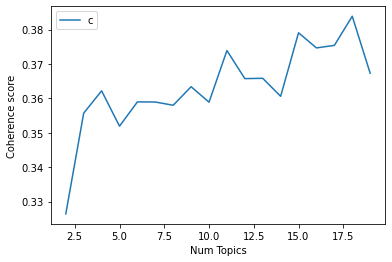

In [42]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

**Conclusion**:  

 - **Best Model**:  The best performing model with default parameters was the **Latent Dirichlet Allocation** method.  
 - **Best Number of Topics**: According to the Coherence measure, there are several potential topic candidates.  There appears to be one at `11` and `13`.
 
**Note:** We know from the dataset, there are `6` product categories. There isn't a correct answer with the number of topics; therefore, we can use `6` or `11`.  When you have many topics, you risk words appearing in more than one resulting in overlapping topics.

## Topic Visualization

Based on the above coherence score, we will try to run the visualization with `6` topics and adapt the number from there based on the visualization results.

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [43]:
NUM_TOPICS = 6

In [44]:
# Build LDA model
model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)

In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, bow_corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_viz)

**How to Interpret**

 - Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent that topic is.
 - A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of clustered in one quadrant.
 - A model with too many topics will typically have many overlaps, small-sized bubbles clustered in one region of the chart.
 
**Results**:  
 
After running the model with various topics, `6` seemed to bring the most clarity using the above interpretation.  We can see that there are slight overlaps for topics `1`, `4`, and `3`, and `5` but not significant.  The rest of the topics are fairly large and do not overlap.